<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/Model_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple tutorial on exploratory model building on a subset of the Airbnb dataset.

In this introductory notebook, we will take a closer look at the Airbnb data. This is by no means a "perfect" analysis, but serves only as an introduction to how one might approach a problem such as the one at hand. So the analyses performed are only meant as a kind of inspiration for your own models.

The variable selection is arbitrary and not every potentially valuable variable is used. We will for instance only use some of the structural variables and the images, but no text data.

In this simple tutorial you will learn:

* How to read in and read out the images for modeling.
* How to deal with missing data
    * Simple imputation transformations to fill in missing values, such as using the median
* How to preprocess structural variables
* Creating base models for the structural variables for data exploration.
    * Simple linear regression
    * Decision Tree Regression
    * Random Forest Regression
* How to create a Multi Layer Perceptron (MLP).
    * How to use sklearn and tensorflow.keras
* How to build a basic Convolutional Neural Network (CNN).
* Predicting the RMSE using your CNN architecture.
* How to build a CNN with multiple inputs and mixed data.


The goal of your analyses is to build a model that predicts Airbnb rental prices fairly accurately while providing good interpretability.


## Index
#### 1. Load the data and scrape the images

#### 2. Data Exploration

#### 3. Model building using only the structural variables

#### 4. Model building using the images


# 1. Load the data

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import matplotlib.image as mpimg
from tqdm import tqdm

import seaborn as sns

I chose only to use the first 1000 observations of the available data to have a faster computation time.
In this tutorial we will not use the 4 datasets loaded below but will solely focus on the listings.csv.gz file.

In [11]:
listings = pd.read_csv("listings.csv")[0:500]
reviews = pd.read_csv("reviews.csv")[0:500]
reviews_meta = pd.read_csv("reviews.csv.gz")[0:500]
calendar = pd.read_csv("calendar.csv.gz")[0:500]

Load the main data file

In [126]:
train_df = pd.read_csv("listings.csv.gz")[0:1000]

In [127]:
# drop all rows where no pictures are available
train_df = train_df.dropna(subset=["picture_url", "host_picture_url"])
train_df = train_df.reset_index(drop=True)

Unfortunately, the variable we are interested in, the price, is given in a string format in the form of  "10.00$".

For easier computation we transform these strings into floats

In [128]:
# transform price
train_df["price"] = (
    train_df["price"].str.replace("$", "").str.replace(",", "").astype(float)
)

Additionaly let's compute the log price, as predicting the log price gives us some advantages we will see later in the notebook

In [129]:
train_df["log_price"] = np.log(train_df["price"])

As you can see below, we have an enormous amount of available data (75 columns + additional files). However, some of these variables contain essentially the same or extremely correlated information. For example, I would guess that the sentiment of a written review is highly correlated with the given *star* rating.

In [130]:
train_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Let's have a quick look at the data. We have 75 columns with a lot of variables that probably do not bare any explanation in them at all.

In [131]:
train_df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,log_price
0,15883,https://www.airbnb.com/rooms/15883,20211107161644,2021-11-08,b&b near Old Danube river,"Four rooms, each one differently and individua...",small and personal<br /><br />Four rooms at th...,https://a0.muscache.com/pictures/18eff738-a737...,62142,https://www.airbnb.com/users/show/62142,Eva,2009-12-11,"Vienna, Wien, Austria",Mein größtes Hobby: Reisen! Am liebsten mit me...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/24166...,https://a0.muscache.com/im/pictures/user/24166...,Donaustadt,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Vienna, Austria",Donaustadt,NaN,48.24262,16.42767,Room in bed and breakfast,Hotel room,3,NaN,1 private bath,1.0,2.0,"[""Essentials"", ""Smoke alarm"", ""Free street par...",120.0,1,365,1,1,365,365,1.0,365.0,NaN,t,29,59,89,364,2021-11-08,14,3,0,2017-11-19,2019-07-17,4.71,4.86,4.93,4.93,4.86,4.71,4.50,NaN,f,3,1,0,0,0.29,4.787492
1,38768,https://www.airbnb.com/rooms/38768,20211107161644,2021-11-08,central cityapartement- wifi- nice neighbourhood,39m² apartment with beautiful courtyard of the...,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,https://www.airbnb.com/users/show/166283,Hannes,2010-07-14,"Wien, Wien, Austria",I am open minded and like travelling myself. I...,NaN,NaN,NaN,t,https://a0.muscache.com/im/users/166283/profil...,https://a0.muscache.com/im/users/166283/profil...,Leopoldstadt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Vienna, Austria",Leopoldstadt,NaN,48.21924,16.37831,Entire rental unit,Entire home/apt,5,NaN,1 bath,1.0,3.0,"[""Shared patio or balcony"", ""Iron"", ""Portable ...",61.0,3,100,3,3,1125,1125,3.0,1125.0,NaN,t,11,20,50,140,2021-11-08,334,11,2,2012-06-16,2021-09-05,4.75,4.80,4.66,4.91,4.93,4.74,4.70,NaN,t,3,3,0,0,2.92,4.110874
2,40625,https://www.airbnb.com/rooms/40625,20211107161644,2021-11-08,"Near Palace Schönbrunn, Apt. 1",Welcome to my Apt. 1!<br /><br />This is a 2be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,https://www.airbnb.com/users/show/175131,Ingela,2010-07-20,"Vienna, Wien, Austria",I´m originally from Sweden but have been livin...,within a few hours,97%,81%,t,https://a0.muscache.com/im/users/175131/profil...,https://a0.muscache.com/im/users/175131/profil...,Rudolfsheim-Fünfhaus,16.0,16.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Vienna, Austria",Rudolfsheim-Fnfhaus,NaN,48.18434,16.32701,Entire rental unit,Entire home/apt,6,NaN,1 bath,2.0,4.0,"[""Wine glasses"", ""Clothing storage: wardrobe a...",131.0,1,180,1,3,180,180,1.0,180.0,NaN,t,0,0,5,275,2021-

### "Scrape" the images

First, we try to scrape the available images: 

This loop, as terrible as it is written, loops through the given flat-picture and host-picture URL's and appends the scraped pictures to two lists. We resize the images to a size of 224 by 224 pixels and normalize them by dividing through 255 (the maximum pixel value). All images that cannot be scraped or are not with rgb are dropped from the dataframe. This is obviously optional and can be handled differently by your approach.

The used picture size of 224x224 is also done randomly. Have in mind, however, that larger pixel values (while maybe giving you better prediction results) will give you longer computation times. However, using e.g. 8x8 images as is sometimes done with the MNIST data sets will give you unrecognizable flat images.

Depending on your number of observations this can take a while. Therefore it is sensible for you (if you haven't already) to start your analysis by scrapping all images and (obviously) saving them.

In [132]:
pictures_flat = []
pictures_host = []
for i in tqdm(range(len(train_df))):

    # retrieve image from url
    
    response_flat = requests.get(train_df["picture_url"][i])
    response_host = requests.get(train_df["host_picture_url"][i])

    # resize images so they all have the same size
    img_flat = Image.open(BytesIO(response_flat.content)).resize([64, 64])
    img_host = Image.open(BytesIO(response_host.content)).resize([64, 64])

    # normalize (divide by maximum pixel value (255))
    img_flat = np.array(img_flat) / 255.0
    img_host = np.array(img_host) / 255.0
    
    try:
        # check shape for nn input
        if img_flat.shape != (64, 64, 3):
            img_flat = img_flat[:, :, 0:3]
            
        if img_host.shape != (64, 64, 3):
            img_host = img_host[:, :, 0:3]
         
        # append the images to the created empty lists
        pictures_flat.append(img_flat)
        pictures_host.append(img_host)
            
    except IndexError:
        train_df = train_df.drop([i])


100%|██████████| 999/999 [06:28<00:00,  2.57it/s]


In [133]:
train_df["pic_host"] = pictures_host
train_df["pic_flat"] = pictures_flat

In [134]:
train_images_flat = np.asarray(pictures_flat)
train_images_host = np.asarray(pictures_host)

In [135]:
#@title
np.median(train_df["price"])

66.0

# 2. Data Exploration

First we take a closer look at the price distribution of the given data.
We can clearly see that we have a wide range of prices and very few observations at the very top of the price range.
The average airbnb apartment is rented for \$101.5 per night. The median lies at 72. 

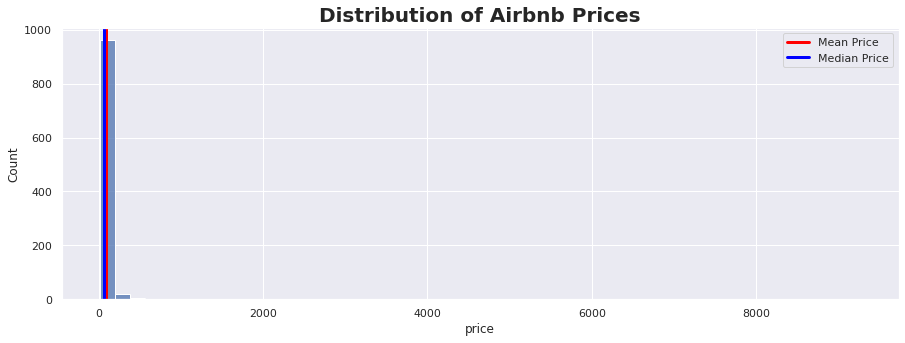

In [22]:
sns.set(rc={"figure.figsize": (15, 5)})
fig = plt.figure()
sns.histplot(data=train_df, x="price", bins=50)
plt.axvline(train_df["price"].mean(), c="red", ls="-", lw=3, label="Mean Price")
plt.axvline(train_df["price"].median(), c="blue", ls="-", lw=3, label="Median Price")
plt.title("Distribution of Airbnb Prices", fontsize=20, fontweight="bold")
plt.legend()
plt.show()

Sometimes it might be advisable to take a closer look at the log-distribution of the prices, which, often depending on the chosen sample size, looks pretty much like a normal distribution.

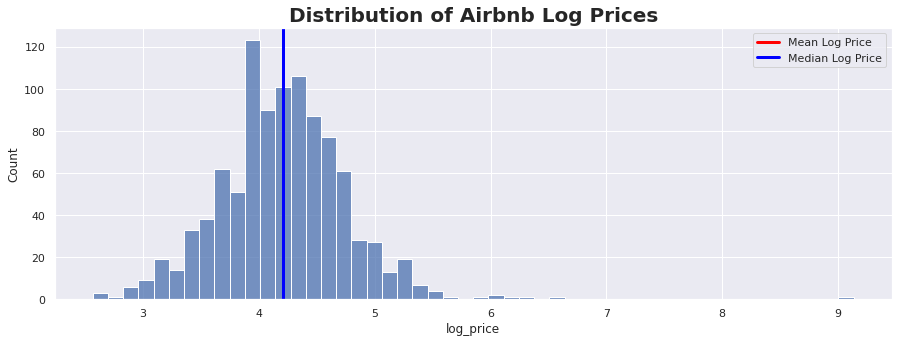

In [27]:
sns.set(rc={"figure.figsize": (15, 5)})
fig = plt.figure()
sns.histplot(data=train_df, x="log_price", bins=50)
plt.axvline(train_df["log_price"].mean(), c="red", ls="-", lw=3, label="Mean Log Price")
plt.axvline(
    train_df["log_price"].median(),
    c="blue",
    ls="-",
    lw=3,
    label="Median Log Price",
)
plt.title("Distribution of Airbnb Log Prices", fontsize=20, fontweight="bold")
plt.legend()
plt.show()

Additionaly we take a closer look at some of the variables which are chosen at random, although I do expect that the chosen 3 variables, namely the room type, whether the host is a so-called "superhost" and the number of people the apartment accomodates has a significant impact on the rental price. However, this is by no means validated and thus you should not be too strongly influenced by my choice.

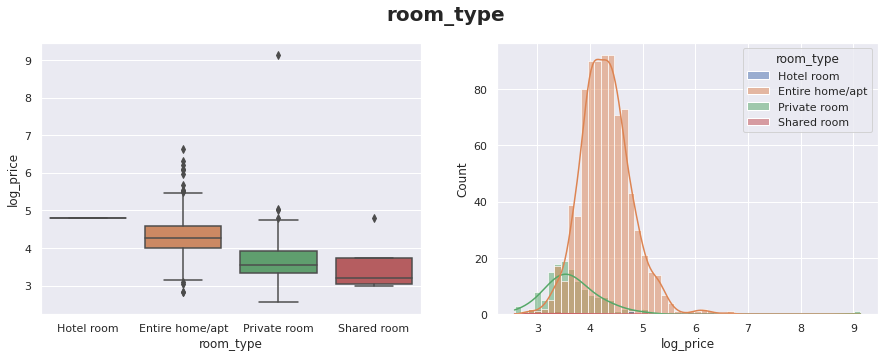

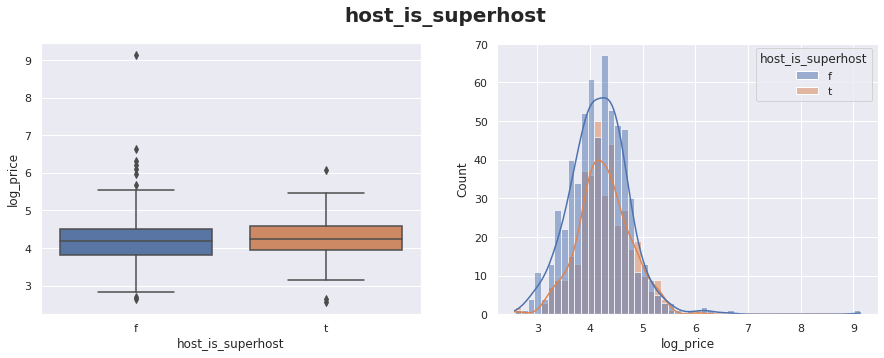

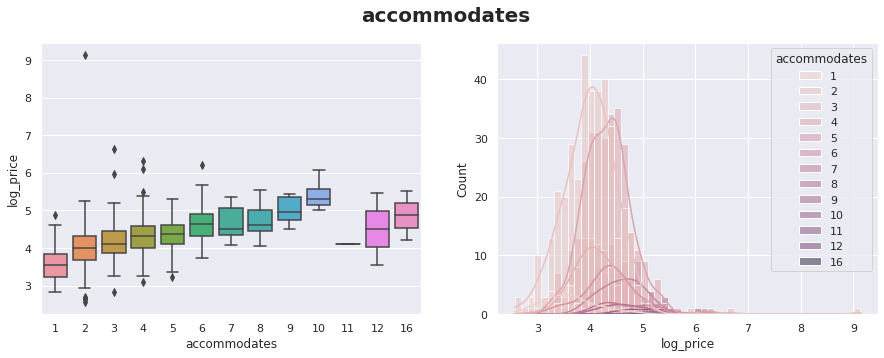

In [28]:
feature_variables = [
    "room_type",
    "host_is_superhost",
    "accommodates",
]

# for each of the above listed feature variables
# show a boxplot and distribution plot against the log price
for variable in feature_variables:
    fig, ax = plt.subplots(1, 2)
    sns.boxplot(data=train_df, x=variable, y="log_price", ax=ax[0])
    sns.histplot(train_df, x="log_price", hue=variable, kde=True, ax=ax[1])
    plt.suptitle(variable, fontsize=20, fontweight="bold")
    fig.show()

Now, we take a look at the host images and the flat images. Therefore we write a simple function that plots the stored images and labels them with the given apartment rental price. 

In [29]:
def plot_images_and_prices(
    df, desired_price=None, num_images=5, random_state=202, pics="pic_host"
):
    """plots images and respective prices

    Args:
        df (pd.DataFrame): DataFrame eveyrthing is stored in. Prices and images as arrays
        desired_price (float, optional): If you want to only view images with a specified rental price. Defaults to None.
        num_images (int, optional): Number of images to be plotted. Defaults to 5.
        random_state (int, optional): . Defaults to 101.
        pics (str, optional): column Name in df where images are stored. Defaults to "pic_host".
    """

    num_images = num_images

    # set the rample state for the sampling for reproducibility
    random_state = random_state

    # only select entries with given price when specified
    if desired_price != None:
        random_sample = (
            df[df["price"] == desired_price]
            .sample(num_images, random_state=random_state)
            .reset_index(drop=True)
        )
    else:
        random_sample = df.sample(num_images, random_state=random_state)

    for i in range(num_images):

        price = random_sample.iloc[i]["price"]
        plt.subplot(1, num_images, i + 1)

        title = price
        plt.title(title)

        # turn off gridlines
        plt.axis("off")

        plt.imshow(random_sample.iloc[i][pics])
    plt.show()
    plt.close()

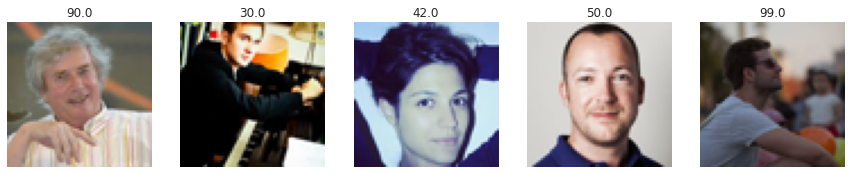

In [30]:
# plot the hosts
plot_images_and_prices(train_df)

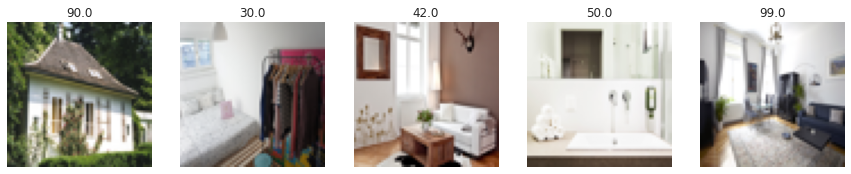

In [31]:
# plot the flats
plot_images_and_prices(train_df, pics="pic_flat")

# 3. Model building

To create a model, simpler models are first examined. This can be used, for example, to select the appropriate variables, since simple models often offer good interpretability. 

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.impute import SimpleImputer

from math import e

First, we select only a few of the variables for easier computation. An adewuate variable selection will be of crucial importance for your model, however, for this simple introduction I just picked what I thought might be reasonable. Additionaly, I chose variables that might be correlated with one another as bedrooms and beds, but did not adjust for that in my modeling as you might see later.

We choose the log-price as Y, as we will start with a simple linear regression where the normality assumption is crucial.

As the chosen feature variables we selected:

* "host_is_superhost"
* "latitude"
* "longitude"
* "room_type"
* "accommodates"
* "bedrooms"
* "number_of_reviews"
* "review_scores_value"


Most of these are self explanatory, but you can look up their exact meaning at: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896

In [136]:
Y = train_df["log_price"]

train_df = train_df[
    [
        "host_is_superhost",
        "latitude",
        "longitude",
        "room_type",
        "accommodates",
        "bedrooms",
        "minimum_nights",
        "number_of_reviews",
        "review_scores_value",
        "host_identity_verified",
    ]
]

There are several ways to deal with missing data. The obvious one is to simply drop all rows where you encounter any missing (or unreasonable, e.g. 10 billion beds) values. Sometimes this might even be advisable. However, I chose to use a fairly straight forward method by simply replacing the missing values with the respective median values of the features. I chose the median, as the mean of e.g. number of bedrooms is not really meaningful, with e.g. 1.19.

Additionally we dummy decode the column "room_type", hus creating additional columns.

In [137]:
train_df.isna().sum()

host_is_superhost          0
latitude                   0
longitude                  0
room_type                  0
accommodates               0
bedrooms                  95
minimum_nights             0
number_of_reviews          0
review_scores_value       86
host_identity_verified     0
dtype: int64

In [138]:
imputer = SimpleImputer(strategy="median")


imputer = imputer.fit(
    train_df[
        [
            "accommodates",
            "bedrooms",
            "number_of_reviews",
            "review_scores_value",
            "minimum_nights",
        ]
    ]
)

train_df[
    [
        "accommodates",
        "bedrooms",
        "number_of_reviews",
        "review_scores_value",
        "minimum_nights",
    ]
] = imputer.transform(
    train_df[
        [
            "accommodates",
            "bedrooms",
            "number_of_reviews",
            "review_scores_value",
            "minimum_nights",
        ]
    ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [139]:
rooms = pd.get_dummies(train_df["room_type"], prefix="room")
train_df = train_df.drop("room_type", axis=1)
train_df["host_is_superhost"] = train_df["host_is_superhost"].map(dict(t=1, f=0))
train_df["host_identity_verified"] = train_df["host_identity_verified"].map(
    dict(t=1, f=0)
)
train_df = pd.concat([train_df, rooms], axis=1)
train_df

,host_is_superhost,latitude,longitude,accommodates,bedrooms,minimum_nights,number_of_reviews,review_scores_value,host_identity_verified,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room
0,0,48.24262,16.42767,3.0,1.0,1.0,14.0,4.50,1,0,1,0,0
1,1,48.21924,16.37831,5.0,1.0,3.0,334.0,4.70,1,1,0,0,0
2,1,48.18434,16.32701,6.0,2.0,1.0,162.0,4.73,1,1,0,0,0
3,1,48.21778,16.37847,3.0,1.0,3.0,324.0,4.56,1,1,0,0,0
4,1,48.21760,16.38018,2.0,1.0,2.0,117.0,4.71,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,1,48.17406,16.35630,3.0,1.0,1.0,1.0,4.00,1,1,0,0,0
995,0,48.22429,16.36727,2.0,1.0,2.0,0.0,4.72,0,0,0,1,0
996,0,48.20087,16.33070,3.0,1.0,1.0,0.0,4.72,0,1,0,0,0
997,0,48.17834,16.42143,4.0,2.0,2.0,42.0,4.83,1,1,0,0,0


For a visual interpretation of our following model results we define a simple plotting function that plots the actual prices vs our predicted prices

In [70]:
# let's see what our predictions look like vs the actual
def ActualvPredictionsGraph(test_y, pred_y, title, prob=False):
    if max(test_y) >= max(pred_y):
        my_range = int(max(test_y))
    else:
        my_range = int(max(pred_y))
    plt.figure(figsize=(12, 3))
    plt.scatter(range(len(test_y)), test_y, color="blue")
    plt.scatter(range(len(pred_y)), pred_y, color="red")
    plt.xlabel("Index ")
    plt.ylabel("Log_price")
    plt.title(title, fontdict={"fontsize": 15})
    plt.legend(
        handles=[
            mpatches.Patch(color="red", label="prediction"),
            mpatches.Patch(color="blue", label="actual"),
        ]
    )
    plt.show()

    if prob:
        # plot actual v predicted in histogram form
        plt.figure(figsize=(12, 4))
        sns.histplot(predict_test, color="r", alpha=0.3, stat="probability", kde=True)
        sns.histplot(test_y, color="b", alpha=0.3, stat="probability", kde=True)
        plt.legend(labels=["prediction", "actual"])
        plt.title("Actual v Predict Distribution" + str(title))
        plt.show()

Before we start modelling, we need to agree on an evaluation method. Obviously for a simple linear regression we could use the R^2, adjusted R2 or AIC metric, but as later we are introducing neural networks I want to use a simple and straight forward method of evluating the model predictions. For that purpose we will use the Root Mean Square Error (RMSE) metric.

\begin{equation}
RMSE = \sqrt {\sum_{i=1}^{n} \frac{\hat{y_i} - y_i}{n}},
\end{equation}

where $\hat{y}$ is the predicted price. Be aware that the imported function is only the Mean Squared Error (MSE) which is why we take the squareroot by using **0.5


For that purpose we will split our data set into a training data set and a testing data set.

In [140]:
train_x, test_x, train_y, test_y = train_test_split(
    train_df, Y, test_size=0.25, random_state=0
)

First, lets try a "stupid model" that only predicts the mean of the training data, in our case the mean log price of the training data. 

In [72]:
def stupid_model_prediction(y_train, y_test):
    a = np.empty(len(test_y))
    a.fill(np.mean(train_y))
    return a


pred_y = stupid_model_prediction(train_y, test_y)

In [73]:
print("RMSE on test data: ", mean_squared_error(test_y, pred_y) ** (0.5))

RMSE on test data:  0.5395519960454388


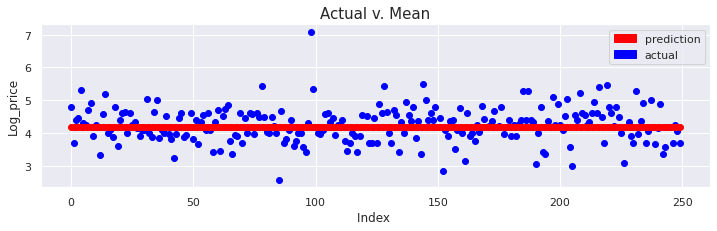

In [74]:
ActualvPredictionsGraph(test_y, pred_y, "Actual v. Mean")

## Linear Regression Model

You should all be familiar with the simple linear regression model. 
\begin{equation}
\mathbf{Y} = \mathbf{X}\mathbf{\beta} + \mathbf{\epsilon}
\end{equation}
However, you might not have fitted a regression using python. 

To use a linear regression in python is similarly easy as it is using it in R. Unfortunately, sklearn does not offer a summary as nice as the R-version does. If you are interested in a similar regression output you could use e.g. statsmodels or create the output yourself by e.g. using sklearns metrics as the introduced MSE.

In [75]:
model_LR = LinearRegression()

# fit the model with the training data
model_LR.fit(train_x, train_y)

predict_train = model_LR.predict(train_x)
predict_test = model_LR.predict(test_x)
# Root Mean Squared Error on train and test date

print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.48457965938058567
RMSE on test data:  0.4697912699502244


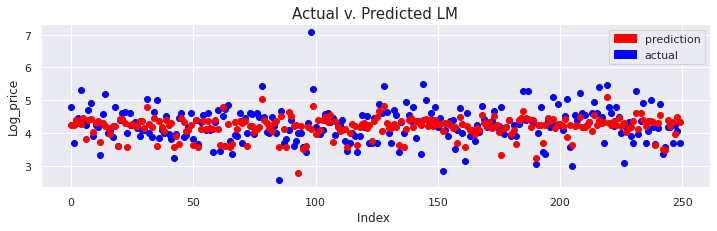

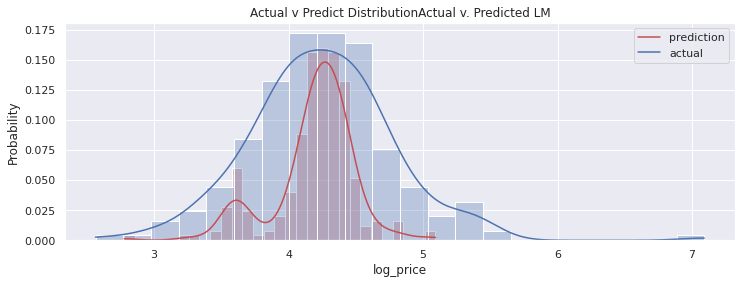

In [76]:
# plot it
ActualvPredictionsGraph(test_y, predict_test, "Actual v. Predicted LM", prob=True)

Decision trees are algorithms that can be used in both, regression and classification. They are basically using a set of binary rules and are thus very easy to interpret. A decision tree, just as a real tree has subsequently branches, nodes and leaves.

A tree could e.g. look something like this:

<img src="Screen-Shot-2019-05-17-at-00.09.26.png">

For more information on decision trees see e.g. https://gdcoder.com/decision-tree-regressor-explained-in-depth/ (where this graphic is taken from) 

In [77]:
tree_reg = DecisionTreeRegressor(max_depth=3, min_samples_split=10)

# train the model
tree_reg.fit(train_x, train_y)

# predict the response for the test data
predict_train = tree_reg.predict(train_x)
predict_test = tree_reg.predict(test_x)

# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.4699871562103687
RMSE on test data:  0.4882896883721667


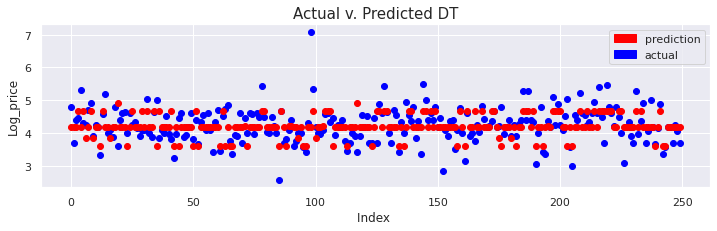

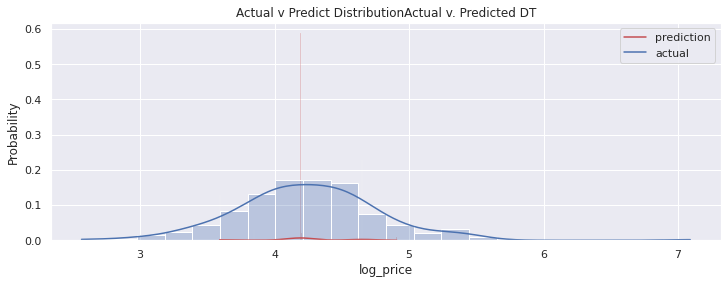

In [78]:
ActualvPredictionsGraph(test_y, predict_test, "Actual v. Predicted DT", prob=True)

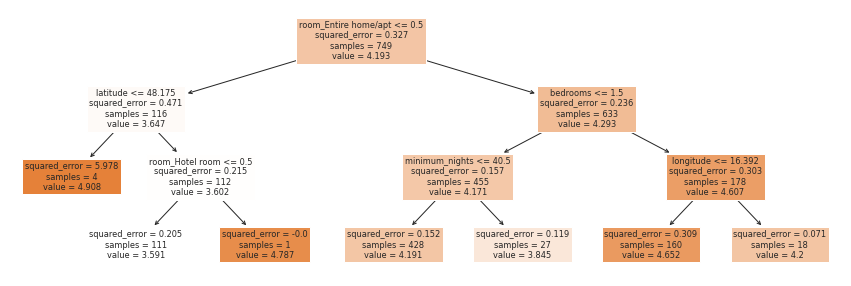

In [79]:
# visualize the decision tree
fig = plt.figure(figsize=(15, 5))
plot = tree.plot_tree(
    tree_reg, feature_names=train_x.columns.values.tolist(), filled=True
)

The overall performance of the decision trees is fairly similar to the performance of a simple linear regression. However, wee see an accumulation of predictions around certain prices due to the inherent model structure of binary decisions.

A similar and very common approach is a random forest regression:

In [80]:
model_RFR = RandomForestRegressor(max_depth=10)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.22172390138400191
RMSE on test data:  0.46598052172149124


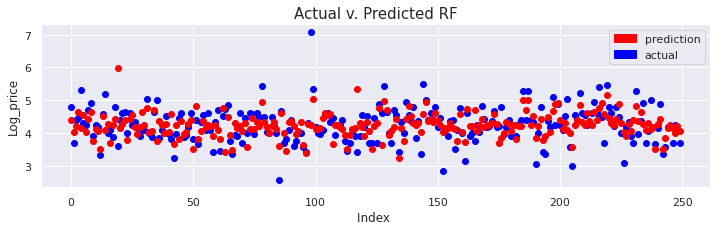

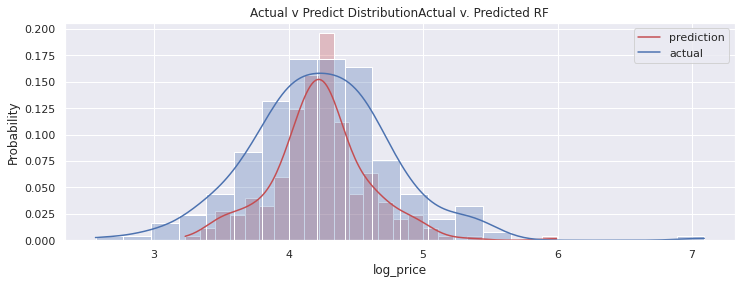

In [81]:
ActualvPredictionsGraph(test_y, predict_test, "Actual v. Predicted RF", prob=True)


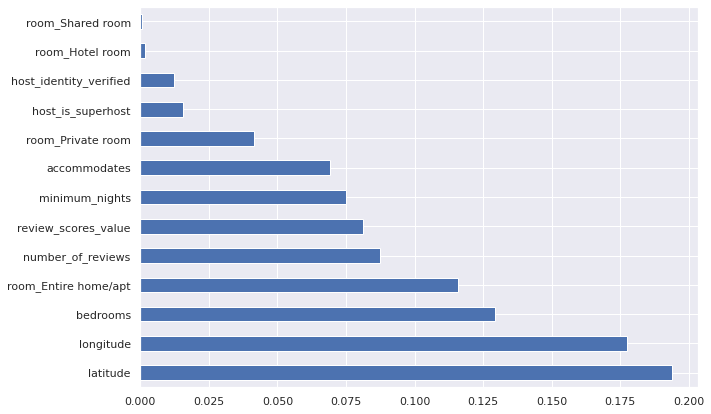

In [82]:
plt.figure(figsize=(10, 7))
feat_importances = pd.Series(model_RFR.feature_importances_, index=train_x.columns)
feat_importances.nlargest(train_df.shape[1]).plot(kind="barh")

This plot gives the "importance" of our input variables/features in the model. This could e.g. give us a reason to drop some of our used variables.

Now we want to build our first Multi Layer Perceptron. In this Notebook I will be using firstly the very inflexible MLPRegressor from scikit-learn and secondly a simple Tensorflow-Keras Implementation. You are, however, by no means in any way restricted and can use e.g. Tensorflow, Pytorch, Caffe or any other library you find suitable or implement everything on your own.

Commonly the weights in neural networks are initialized to random small numbers (most often with a random draw from a truncated normal distribution with mean=0 and variance=1) and updated with a given (and often cahnging/flexible) small learning rate.
Given this use of small weights the scale of inputs (and outputs) is an important factor. Unscaled input variables can result in a slow or unstable learning process which in turn can lead to a bad performance. Unscaled output variables (in our case the price) can lead to exploding gradients.

As we have already scaled our prices with a log-transformation we will apply a MinMax Scaling approach to our input variables.



\begin{equation}
x_{scaled} = \frac{x - min(x)}{max(x) - min(x)}
\end{equation}


###### As you can see in the formula this has no effect on the dummy variables. However, our implementation has an effect on the "categorical" variables as e.g. "accommodates" or "beds". It might therefore maybe be more approriate to use e.g. One-Hot-Encoding for the categorical variables. I have not implemented this in the present notebook as this is purely introductory, so you should definetly have in mind that the variables selection, feature extraction and preprocessing is a very important part of your model building and should not simply be copied from this notebook 

In [87]:
# try with minmax scaled data -> also usefull for MLP
mn = MinMaxScaler()
x_train_scaled = pd.DataFrame(mn.fit_transform(train_x), columns=train_x.columns)
x_test_scaled = pd.DataFrame(mn.fit_transform(test_x), columns=test_x.columns)

In [88]:
MLPreg = MLPRegressor(
    hidden_layer_sizes=(1),
    activation="relu",
    random_state=101,
    max_iter=2000,
).fit(x_train_scaled, train_y)

In [52]:
predict_train = MLPreg.predict(x_train_scaled)
predict_test = MLPreg.predict(x_test_scaled)
# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.5051021763573206
RMSE on test data:  0.7239624207002432


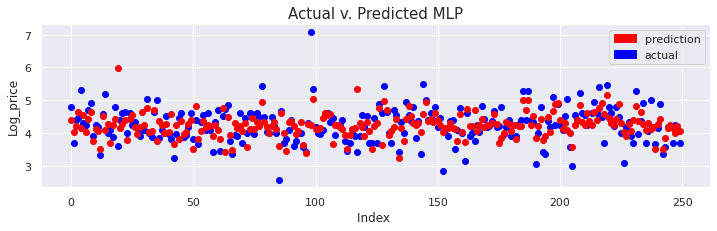

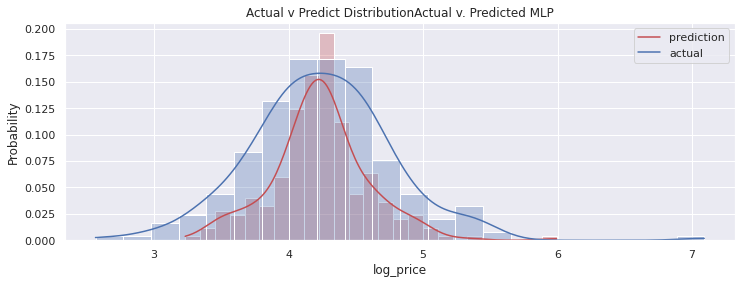

In [90]:
ActualvPredictionsGraph(test_y, predict_test, "Actual v. Predicted MLP", prob=True)


Now let's implement a simple MLP with tensorflow Keras:

In [91]:
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    Dropout,
    MaxPool2D,
    AveragePooling2D,
    Input,
    Activation,
    BatchNormalization,
    MaxPooling2D,
    concatenate,
)
from tensorflow.keras.callbacks import EarlyStopping

In [92]:
# first define the validation split, number of epochs and the batch size

split = 0.2
epochs = 200
batch_size = 64

In [93]:
# lets create a susper simple model with just 1 layer

model = Sequential()
model.add(Dense(1, activation="linear", input_shape=(x_train_scaled.shape[1],)))

In [95]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [96]:
model.compile(optimizer="adam", loss="mse", metrics="mae")

history = model.fit(
    x_train_scaled,
    train_y,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/200
10/10 [==============================] - 0s 18ms/step - loss: 14.8060 - mae: 3.7975 - val_loss: 14.3701 - val_mae: 3.7574
Epoch 2/200
10/10 [==============================] - 0s 5ms/step - loss: 14.4099 - mae: 3.7452 - val_loss: 13.9710 - val_mae: 3.7042
Epoch 3/200
10/10 [==============================] - 0s 5ms/step - loss: 14.0163 - mae: 3.6927 - val_loss: 13.5808 - val_mae: 3.6515
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 13.6355 - mae: 3.6411 - val_loss: 13.1968 - val_mae: 3.5988
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 13.2591 - mae: 3.5892 - val_loss: 12.8220 - val_mae: 3.5466
Epoch 6/200
10/10 [==============================] - 0s 6ms/step - loss: 12.8895 - mae: 3.5379 - val_loss: 12.4543 - val_mae: 3.4946
Epoch 7/200
10/10 [==============================] - 0s 4ms/step - loss: 12.5306 - mae: 3.4869 - val_loss: 12.0951 - val_mae: 3.4430
Epoch 8/200
10/10 [==============================] - 0s 4ms/step - l

8/8 [==============================] - 0s 2ms/step - loss: 0.4183 - mae: 0.4741


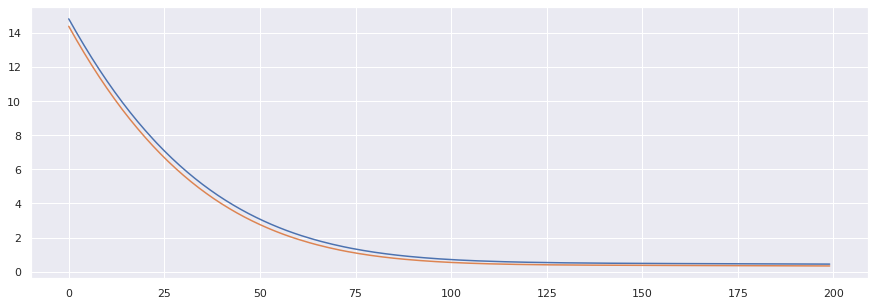

In [97]:
loss, mae = model.evaluate(x_test_scaled, test_y)
# Step4.2 Plot the learning curve
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.show()

In [98]:
predict_train = model.predict(x_train_scaled)
predict_test = model.predict(x_test_scaled)
# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.6508122678038541
RMSE on test data:  0.6467531867628261


# Activation Functions

For this implementation, we will only use two activation functions, namely the Rectified Linear Uni activation function and the linear activation function. However there are obviously multiple other alternatives which could be used.
The two used activation functions are so-called Ridge functions, as they are multivariate functions acting on a linear combination of the input variables. 

### Rectified Linear Activation Function:

\begin{equation}
f (x) = \left\{
\begin{array}{ll}
x & x > 0 \\
0 & \, \textrm{else} \\
\end{array}
\right.
\end{equation}

The ReLU activation function is pretty simple. It is 0, once x is smaller or equal to zero and x, whenever x is bigger than zero. We could write this function in a loop simply as:
```
outputs = []
for value in inputs:
    if value > 0:
        outputs.append(x)
    elif value <= 0:
        outputs.append(0)    
```

However, this can easily be done in one line, by simply taking the maximum between the value itself and 0:

```
np.maximum(0, value)
```

The derivative of the ReLU function is equally as easy and simply not defined for x = 0:

\begin{equation}
f (x) = \left\{
\begin{array}{ll}
1 & x > 0 \\
0 & x < 0 \\
\end{array}
\right.
\end{equation}

### Linear
just returns the input as it is

Let's define these functions and visualize them. Luckily, when using activation functions in our models, they are impemented in basically all available librarys and can simply be used, e.g. with activation="ReLU" in Tensorflow-Keras.

In [99]:
def ReLU(inputs):
    return np.maximum(0, inputs)

def linear(inputs):
    return inputs


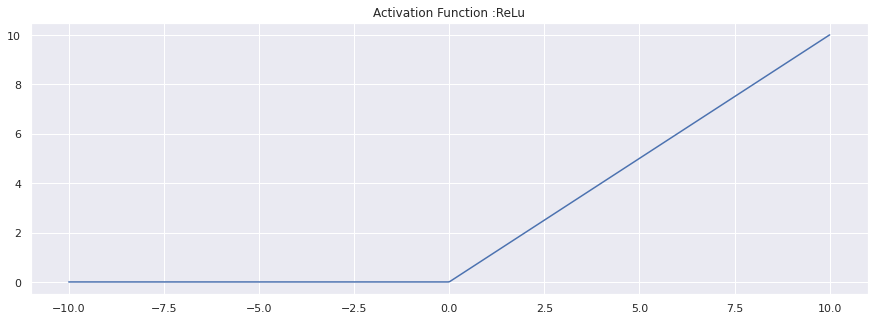

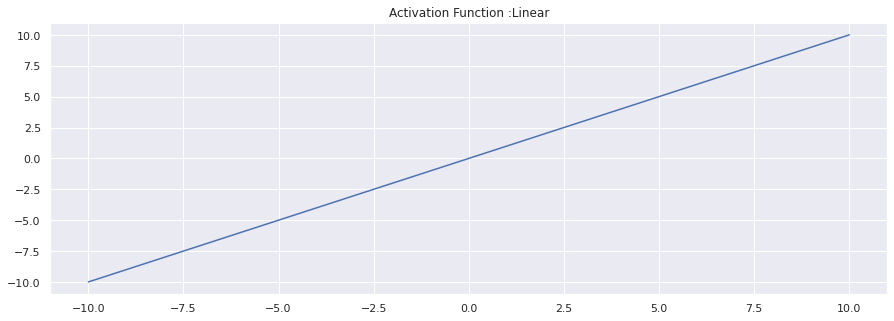

In [100]:
# Now lets first create some artificial input

x = np.linspace(-10, 10, 500)

# And then plot the two activation functions

plt.plot(x, ReLU(x))
plt.title("Activation Function :ReLu")
plt.show()


plt.plot(x, linear(x))
plt.title("Activation Function :Linear")
plt.show()

Now we will build a more complex MLP with multiple Layers, but always use the linear activation function

In [101]:
# let's build a more complex model and increase the number of epochs
epochs = 500

model = Sequential()
model.add(Dense(64, activation="linear", input_shape=(x_train_scaled.shape[1],)))
model.add(Dense(128, activation="linear"))
model.add(Dense(64, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(1, activation="linear"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                896       
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,585
Trainable params: 19,585
Non-trainable params: 0
_________________________________________________________________


The number of parameters for a MLP is very simply calculated by calculating the connections between layers + biases in every layer. 

\begin{equation}
n_{params} = (i×h + h×o) + (h+o)
\end{equation}

where i = input,
h = hidden layers
o = output.

For our model, this gives us:
\begin{equation}
12*64 + 64*128 + 128*64 + 64*32 + 32*1 + 64 + 128 + 64 + 32 +1
= 19521
\end{equation}


In [102]:
model.compile(optimizer="adam", loss="mse", metrics="mae")

history = model.fit(
    x_train_scaled,
    train_y,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/500
10/10 [==============================] - 1s 26ms/step - loss: 7.4159 - mae: 2.2796 - val_loss: 1.6646 - val_mae: 1.1230
Epoch 2/500
10/10 [==============================] - 0s 7ms/step - loss: 1.3997 - mae: 0.9778 - val_loss: 0.3659 - val_mae: 0.4681
Epoch 3/500
10/10 [==============================] - 0s 7ms/step - loss: 0.7138 - mae: 0.6559 - val_loss: 0.3358 - val_mae: 0.4538
Epoch 4/500
10/10 [==============================] - 0s 7ms/step - loss: 0.4766 - mae: 0.5216 - val_loss: 0.3559 - val_mae: 0.4867
Epoch 5/500
10/10 [==============================] - 0s 5ms/step - loss: 0.3892 - mae: 0.4569 - val_loss: 0.2565 - val_mae: 0.3969
Epoch 6/500
10/10 [==============================] - 0s 8ms/step - loss: 0.3563 - mae: 0.4308 - val_loss: 0.2548 - val_mae: 0.4020
Epoch 7/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3480 - mae: 0.4297 - val_loss: 0.2117 - val_mae: 0.3632
Epoch 8/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3388 - 

8/8 [==============================] - 0s 2ms/step - loss: 0.2360 - mae: 0.3618


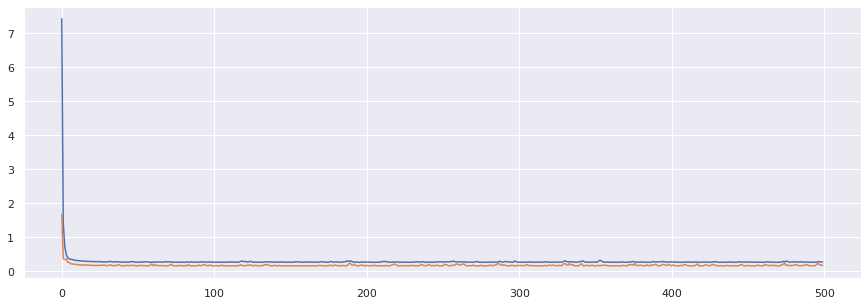

In [103]:
loss, mae = model.evaluate(x_test_scaled, test_y)
# Step4.2 Plot the learning curve
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.show()

In [104]:
predict_train = model.predict(x_train_scaled)
predict_test = model.predict(x_test_scaled)
# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.4910482494940298
RMSE on test data:  0.4857815637182578


Checking the plots it seems like we could have stopped training much earlier than we actually did. Let's define an early stopping criterion and rerun the same model with early stopping

Epoch 1/500
10/10 [==============================] - 1s 24ms/step - loss: 7.8616 - mae: 2.3548 - val_loss: 1.3927 - val_mae: 1.0406
Epoch 2/500
10/10 [==============================] - 0s 8ms/step - loss: 1.5781 - mae: 1.0575 - val_loss: 0.3461 - val_mae: 0.4447
Epoch 3/500
10/10 [==============================] - 0s 6ms/step - loss: 0.7814 - mae: 0.6939 - val_loss: 0.3397 - val_mae: 0.4515
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4584 - mae: 0.5258 - val_loss: 0.3626 - val_mae: 0.5012
Epoch 5/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3703 - mae: 0.4459 - val_loss: 0.2419 - val_mae: 0.3829
Epoch 6/500
10/10 [==============================] - 0s 5ms/step - loss: 0.3555 - mae: 0.4270 - val_loss: 0.2303 - val_mae: 0.3826
Epoch 7/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3381 - mae: 0.4283 - val_loss: 0.1998 - val_mae: 0.3491
Epoch 8/500
10/10 [==============================] - 0s 5ms/step - loss: 0.3250 - 

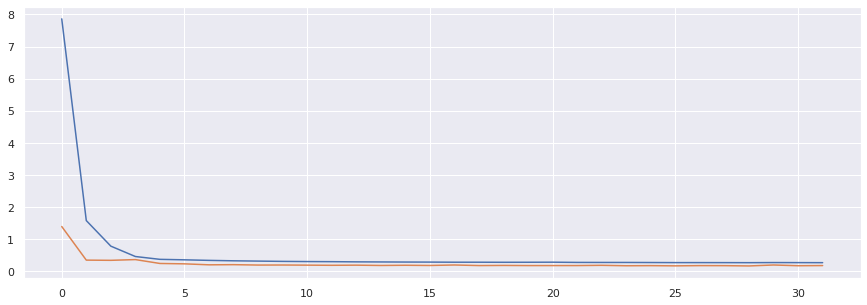

In [105]:
callback = EarlyStopping(monitor="mae", patience=4)


model = Sequential()
model.add(Dense(64, activation="linear", input_shape=(x_train_scaled.shape[1],)))
model.add(Dense(128, activation="linear"))
model.add(Dense(64, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mse", metrics="mae")


history = model.fit(
    x_train_scaled,
    train_y,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback],
)

loss, mae = model.evaluate(x_test_scaled, test_y)
# Step4.2 Plot the learning curve
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.show()

In [106]:
predict_train = model.predict(x_train_scaled)
predict_test = model.predict(x_test_scaled)
# Root Mean Squared Error on train and test date
print("RMSE on train data: ", mean_squared_error(train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(test_y, predict_test) ** (0.5))

RMSE on train data:  0.49687845772957523
RMSE on test data:  0.48544907814542876


If you encounter severe overfitting (another) common pracitce is to add Dropout layers. In Keras that is easily achivable by simply using: model.add(Dropout(dropout_value)). e.g. as done below

Epoch 1/500
10/10 [==============================] - 1s 23ms/step - loss: 7.6090 - mae: 2.2977 - val_loss: 2.8551 - val_mae: 1.4872
Epoch 2/500
10/10 [==============================] - 0s 5ms/step - loss: 2.2040 - mae: 1.1769 - val_loss: 0.5788 - val_mae: 0.5993
Epoch 3/500
10/10 [==============================] - 0s 8ms/step - loss: 1.1140 - mae: 0.8648 - val_loss: 0.3270 - val_mae: 0.4465
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 0.7740 - mae: 0.6841 - val_loss: 0.2845 - val_mae: 0.4248
Epoch 5/500
10/10 [==============================] - 0s 5ms/step - loss: 0.7266 - mae: 0.6528 - val_loss: 0.2339 - val_mae: 0.3833
Epoch 6/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6618 - mae: 0.6240 - val_loss: 0.2121 - val_mae: 0.3578
Epoch 7/500
10/10 [==============================] - 0s 6ms/step - loss: 0.7032 - mae: 0.6302 - val_loss: 0.2190 - val_mae: 0.3729
Epoch 8/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6341 - 

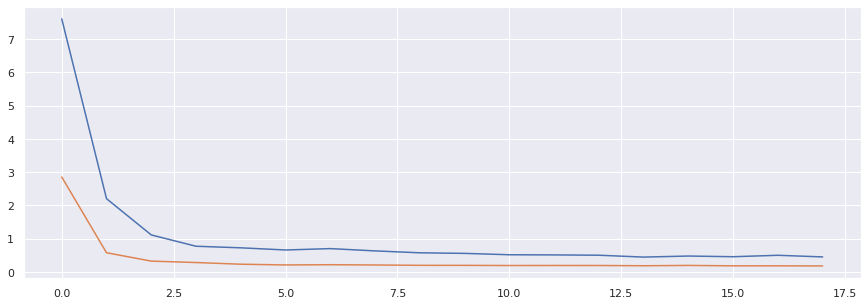

In [107]:
model = Sequential()
model.add(Dense(64, activation="linear", input_shape=(x_train_scaled.shape[1],)))
model.add(Dense(128, activation="linear"))

model.add(Dropout(0.5))

model.add(Dense(64, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mse", metrics="mae")


history = model.fit(
    x_train_scaled,
    train_y,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback],
)

loss, mae = model.evaluate(x_test_scaled, test_y)
# Step4.2 Plot the learning curve
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.show()

# 4. Model building with images

Now lets first try a simple regression simply with the images of the flats. Based on the above quick view of the images we can assume that a regression based on images might not yield the best results

In [141]:
img_train_x, img_test_x, img_train_y, img_test_y = train_test_split(
    train_images_flat, Y, test_size=0.25, random_state=0
)

Epoch 1/100
10/10 [==============================] - 2s 157ms/step - loss: 6.5466 - mae: 2.1217 - val_loss: 2.6633 - val_mae: 1.5483
Epoch 2/100
10/10 [==============================] - 1s 134ms/step - loss: 1.6817 - mae: 1.1011 - val_loss: 0.3908 - val_mae: 0.4877
Epoch 3/100
10/10 [==============================] - 1s 132ms/step - loss: 0.9794 - mae: 0.7774 - val_loss: 0.3933 - val_mae: 0.4985
Epoch 4/100
10/10 [==============================] - 1s 135ms/step - loss: 0.8301 - mae: 0.7155 - val_loss: 0.4969 - val_mae: 0.5480
Epoch 5/100
10/10 [==============================] - 1s 128ms/step - loss: 0.7327 - mae: 0.6674 - val_loss: 0.6129 - val_mae: 0.6301
Epoch 6/100
10/10 [==============================] - 1s 132ms/step - loss: 0.6529 - mae: 0.6487 - val_loss: 0.8867 - val_mae: 0.8004
Epoch 7/100
10/10 [==============================] - 1s 134ms/step - loss: 0.6804 - mae: 0.6409 - val_loss: 0.6671 - val_mae: 0.6713
Epoch 8/100
10/10 [==============================] - 1s 128ms/step - 

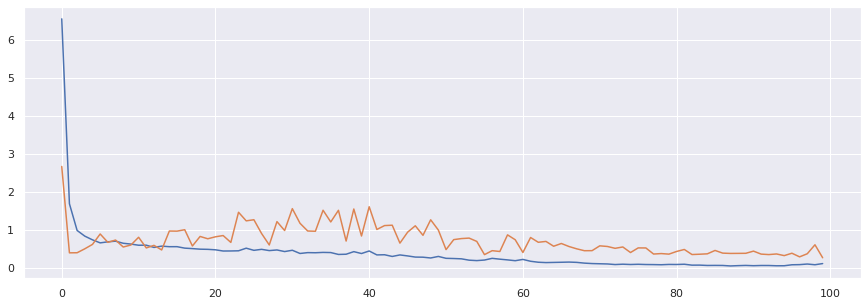

In [142]:
# lets first run the model without early stopping but ionly for 100 epochs
epochs = 100

img_model = Sequential()

img_model.add(
    Conv2D(
        64,
        kernel_size=3,
        strides=2,
        activation="relu",
        padding="SAME",
        input_shape=train_images_flat[0].shape,
    )
)
img_model.add(MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))

img_model.add(
    Conv2D(
        128,
        kernel_size=3,
        strides=2,
        activation="relu",
        padding="SAME",
    )
)
img_model.add(MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))

img_model.add(
    Conv2D(
        64,
        kernel_size=3,
        strides=2,
        activation="relu",
        padding="SAME",
    )
)

img_model.add(Dropout(0.5))
img_model.add(Conv2D(64, kernel_size=3, strides=1, activation="relu", padding="SAME"))
img_model.add(Flatten())
img_model.add(Dense(32, activation="relu"))
img_model.add(Dense(1, activation="linear"))
img_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

img_history = img_model.fit(
    img_train_x,
    img_train_y,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
)


loss, mae = img_model.evaluate(img_test_x, img_test_y)
# Step4.2 Plot the learning curve
plt.plot(img_history.history["loss"], label="train")
plt.plot(img_history.history["val_loss"], label="val")
plt.show()

In [143]:
predict_train = img_model.predict(img_train_x)
predict_test = img_model.predict(img_test_x)
print("RMSE on train data: ", mean_squared_error(img_train_y, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(img_test_y, predict_test) ** (0.5))

RMSE on train data:  0.28714762201980565
RMSE on test data:  0.5553118593168862


Let's write a super ugly own train test split function to get ranom sample from the multiple datasets we have. There probably is a better solution for this, but this still works fine if you are carefull with the order of the arguments

In [144]:
def tt_split(*data, test_size=0.3, random_state=101):
    """Be aware of the input order of your arguments"""

    np.random.seed(random_state)

    len_list = [len(i) for i in data]
    if len(set(len_list)) != 1:
        raise ValueError("Lengths of input data must be identical")

    n = int(np.round(0.3 * len_list[0], 0))

    indexes = np.random.choice(len_list[0], n, replace=False)

    test_list = []
    train_list = []

    for i in range(len(data)):

        try:
            temp = data[i].values
        except AttributeError:
            temp = data[i]

        test_data = temp[indexes]
        train_data = temp[[i for i in range(len(temp)) if i not in indexes]]

        if type(data[i]) == pd.core.frame.DataFrame:
            test_data = pd.DataFrame(test_data, columns=data[i].columns)
            train_data = pd.DataFrame(train_data, columns=data[i].columns)

        test_list.append(test_data)
        train_list.append(train_data)

    return train_list, test_list


x, y = tt_split(train_df, train_images_host, train_images_flat, Y)

X_train, X_test, host_train, host_test, flat_train, flat_test, y_train, y_test = (
    x[0],
    y[0],
    x[1],
    y[1],
    x[2],
    y[2],
    x[3],
    y[3],
)

In [147]:
# model for Photo image
image_inputs = tf.keras.Input((64, 64, 3))

x_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(image_inputs)

x_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(x_image)

x_image = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(x_image)

x_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(x_image)

x_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(x_image)

x_image = tf.keras.layers.Flatten()(x_image)

x_image = tf.keras.layers.Dense(128, activation="relu")(x_image)

x_image = tf.keras.layers.Dropout(0.5)(x_image)


# model for Meta data
meta_inputs = tf.keras.Input(shape=((13,)))

x_meta = tf.keras.layers.Dense(13, activation="relu")(meta_inputs)

x_meta = tf.keras.layers.Dense(24, activation="relu")(x_meta)

x_meta = tf.keras.layers.Dense(12, activation="relu")(x_meta)


# concatenate the "two" models
x = tf.keras.layers.Concatenate(axis=1)([x_image, x_meta])

output = tf.keras.layers.Dense(1)(x)
multi_model = tf.keras.Model(inputs=[image_inputs, meta_inputs], outputs=output)

In [148]:
# compile the model

multi_model.compile(loss="mse", metrics=["mae"], optimizer="adam")

callback = EarlyStopping(monitor="loss", patience=10)

# train the model
multi_model_history = multi_model.fit(
    [host_train, X_train],
    y_train,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback],
)

Epoch 1/100
9/9 [==============================] - 2s 166ms/step - loss: 11.6016 - mae: 2.8773 - val_loss: 1.6714 - val_mae: 0.9845
Epoch 2/100
9/9 [==============================] - 1s 139ms/step - loss: 3.4917 - mae: 1.5803 - val_loss: 1.6929 - val_mae: 1.0412
Epoch 3/100
9/9 [==============================] - 1s 139ms/step - loss: 2.0611 - mae: 1.1045 - val_loss: 0.8307 - val_mae: 0.6749
Epoch 4/100
9/9 [==============================] - 1s 129ms/step - loss: 1.3368 - mae: 0.9091 - val_loss: 1.0673 - val_mae: 0.8115
Epoch 5/100
9/9 [==============================] - 1s 138ms/step - loss: 1.2683 - mae: 0.8876 - val_loss: 0.7954 - val_mae: 0.6606
Epoch 6/100
9/9 [==============================] - 1s 141ms/step - loss: 1.1129 - mae: 0.8088 - val_loss: 0.6925 - val_mae: 0.5948
Epoch 7/100
9/9 [==============================] - 1s 142ms/step - loss: 0.9878 - mae: 0.7730 - val_loss: 0.6671 - val_mae: 0.5949
Epoch 8/100
9/9 [==============================] - 1s 132ms/step - loss: 1.0010 - 

10/10 [==============================] - 0s 20ms/step - loss: 0.1964 - mae: 0.3370


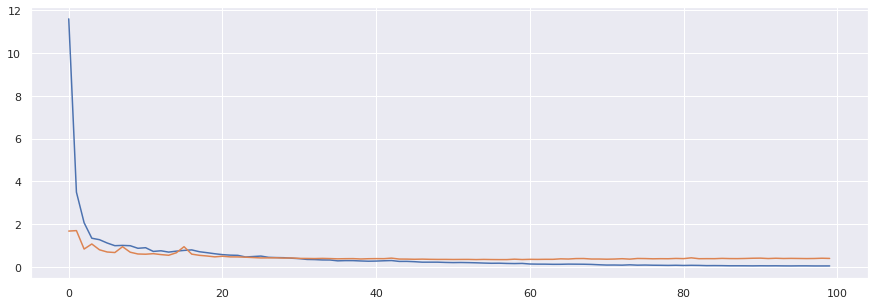

In [149]:
loss, mae = multi_model.evaluate(
    [host_test, X_test],
    y_test,
)
# Step4.2 Plot the learning curve
plt.plot(multi_model_history.history["loss"], label="train")
plt.plot(multi_model_history.history["val_loss"], label="val")
plt.show()

In [150]:
predict_train = multi_model.predict([host_train, X_train])
predict_test = multi_model.predict([host_test, X_test])
print("RMSE on train data: ", mean_squared_error(y_train, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(y_test, predict_test) ** (0.5))

RMSE on train data:  0.32065627294174914
RMSE on test data:  0.4431441572219193


In [151]:
# model for Photo image
image_inputs_x = tf.keras.Input((64, 64, 3))

# for first images
x_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(image_inputs_x)

x_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(x_image)

x_image = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(x_image)

x_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(x_image)

x_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(x_image)

x_image = tf.keras.layers.Flatten()(x_image)

x_image = tf.keras.layers.Dense(128, activation="relu")(x_image)

x_image = tf.keras.layers.Dropout(0.5)(x_image)


# for second images
image_inputs_z = tf.keras.Input((64, 64, 3))

z_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(image_inputs_z)

z_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(z_image)

z_image = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(z_image)

z_image = (MaxPool2D(pool_size=(3, 3), strides=2, padding="VALID"))(z_image)

z_image = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"
)(z_image)

z_image = tf.keras.layers.Flatten()(z_image)

z_image = tf.keras.layers.Dense(128, activation="relu")(z_image)

z_image = tf.keras.layers.Dropout(0.5)(z_image)


# model for Meta data
meta_inputs = tf.keras.Input(shape=((13,)))
x_meta = tf.keras.layers.Dense(13, activation="relu")(meta_inputs)
x_meta = tf.keras.layers.Dense(24, activation="relu")(x_meta)
x_meta = tf.keras.layers.Dense(12, activation="relu")(x_meta)

# concat
x = tf.keras.layers.Concatenate(axis=1)([x_image, x_meta, z_image])
output = tf.keras.layers.Dense(1, activation="linear")(x)

multi_multi_model = tf.keras.Model(
    inputs=[image_inputs_x, meta_inputs, image_inputs_z], outputs=output
)

In [152]:
multi_multi_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 64)   1792        ['input_5[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 64)   1792        ['input_6[0][0]']                
                                                                                            

In [153]:
multi_multi_model.compile(loss="mse", metrics=["mae"], optimizer="adam")

callback = EarlyStopping(monitor="loss", patience=10)

# train the model
multi_multi_model_history = multi_multi_model.fit(
    [host_train, X_train, flat_train],
    y_train,
    validation_split=split,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback],
)

Epoch 1/100
9/9 [==============================] - 4s 293ms/step - loss: 5.7205 - mae: 1.9612 - val_loss: 0.8278 - val_mae: 0.6667
Epoch 2/100
9/9 [==============================] - 2s 259ms/step - loss: 1.5684 - mae: 1.0348 - val_loss: 0.9627 - val_mae: 0.7054
Epoch 3/100
9/9 [==============================] - 2s 253ms/step - loss: 1.1393 - mae: 0.7789 - val_loss: 0.8269 - val_mae: 0.7078
Epoch 4/100
9/9 [==============================] - 2s 251ms/step - loss: 0.8242 - mae: 0.7113 - val_loss: 0.7923 - val_mae: 0.7106
Epoch 5/100
9/9 [==============================] - 2s 252ms/step - loss: 0.6984 - mae: 0.6615 - val_loss: 0.6787 - val_mae: 0.6421
Epoch 6/100
9/9 [==============================] - 2s 254ms/step - loss: 0.6071 - mae: 0.6078 - val_loss: 0.5753 - val_mae: 0.5715
Epoch 7/100
9/9 [==============================] - 2s 248ms/step - loss: 0.5758 - mae: 0.5902 - val_loss: 0.5428 - val_mae: 0.5423
Epoch 8/100
9/9 [==============================] - 2s 244ms/step - loss: 0.5204 - m

10/10 [==============================] - 0s 34ms/step - loss: 0.4489 - mae: 0.4037


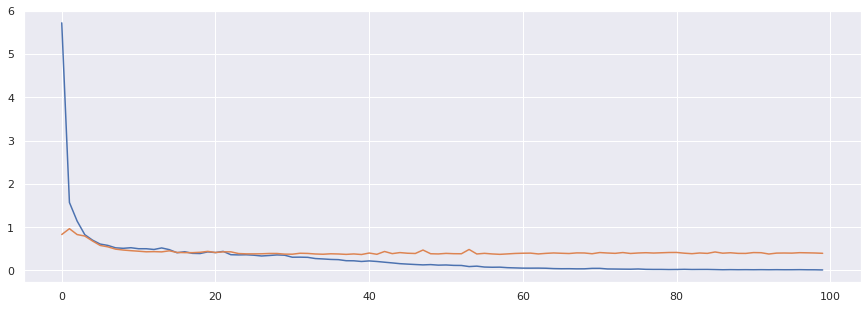

In [154]:
loss, mae = multi_multi_model.evaluate(
    [host_test, X_test, flat_test],
    y_test,
)
# Step4.2 Plot the learning curve
plt.plot(multi_multi_model_history.history["loss"], label="train")
plt.plot(multi_multi_model_history.history["val_loss"], label="val")
plt.show()

In [155]:
predict_train = multi_multi_model.predict([host_train, X_train, flat_train])
predict_test = multi_multi_model.predict([host_test, X_test, flat_test])
print("RMSE on train data: ", mean_squared_error(y_train, predict_train) ** (0.5))
print("RMSE on test data: ", mean_squared_error(y_test, predict_test) ** (0.5))

RMSE on train data:  0.28651234761898486
RMSE on test data:  0.6700301889096423


As this is just an introductory notebook, I again want to emphasize that the performance of these models is arbitrary and should not effect your model or variable choice.

In this notebook we have started with very simple methods, suited to analyse structured data. Even in the performed models any form of optimizing is missing and the variable selection was done at random. Therefore you have plenty of room to build better fitting models using more suitable variables.

Subsequently we have used 3 types of neural networks:
* Multi Layer Perceptrons to analyze structured data
* Convolutional Neural networks to analyze images
* Mixed Input Neural Networks to analyze structured data and images combined

